In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [4]:
train = pd.read_csv('train.csv')
train.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [5]:
test = pd.read_csv('test.csv')
test.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS


### Временно уменьшим датасет

In [6]:
#raw_df = raw_df[:2000]

## Удалим сумму транзакций - в текущей задачи мы ее не предсказываем

In [7]:
train.drop('target_sum', axis=1, inplace=True)

## Все фичи надо варить, причём одинаково в train и test, лучше их сразу соединим 

In [8]:
test['target_flag'] = "y"

In [9]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [10]:
df = pd.concat([train, test])#[:100]

In [11]:
df.index = range(len(df))

In [12]:
df.head(3)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0


# Обработка(парсинг) даты

In [13]:
df['Time_Stamp'] = pd.to_datetime(df['TRDATETIME'], format='%d%b%y:%H:%M:%S')

In [14]:
df['date'] = df['Time_Stamp'].dt.date
df['year'] = df['Time_Stamp'].dt.year
df['month'] = df['Time_Stamp'].dt.month
df['day_Month'] = df['Time_Stamp'].dt.day
df['day_Week'] = df['Time_Stamp'].dt.weekday


In [15]:
df['hour'] = df['Time_Stamp'].dt.hour

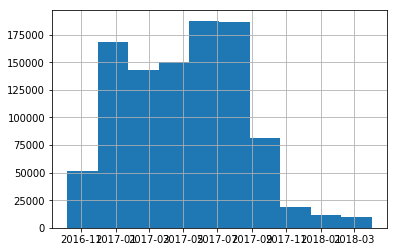

In [16]:
df.date.hist()

In [309]:
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,Time_Stamp,date,year,month,day_Month,day_Week,hour
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,2017-10-21 00:00:00,2017-10-21,2017,10,21,5,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,2017-10-12 12:24:07,2017-10-12,2017,10,12,3,12
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,2017-12-05 00:00:00,2017-12-05,2017,12,5,1,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,2017-10-21 00:00:00,2017-10-21,2017,10,21,5,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,2017-10-24 13:14:24,2017-10-24,2017,10,24,1,13


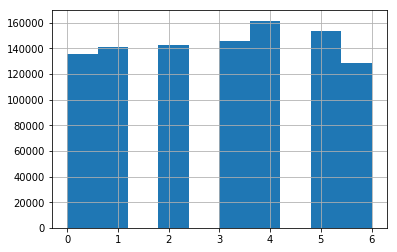

In [17]:
df.day_Week.hist()

# Приведем все транзакции в одну валюту

In [310]:
len(df.currency.value_counts())

67

In [18]:
quotes = pd.read_excel('curr_rates.xlsx.xlsx')

In [19]:
quotes.head()

,CODE,NUM_ISO_CODE,CURRNAME,CURR_DATE,"V.CURR_VAL/NVL(CURR_NOM,1)"
0,INR,356,Индийская рупия,22.03.2017,0.876687
1,EUR,978,Евро,22.03.2017,61.730800
2,HUF,348,Венгерский форинт,22.03.2017,0.200095
3,AMD,51,Армянский драм,22.03.2017,0.118371
4,TJS,972,Таджикский сомони,22.03.2017,7.033160


In [20]:
mean_rates = pd.DataFrame({'mean_rate': quotes.groupby( [ "NUM_ISO_CODE"] )['V.CURR_VAL/NVL(CURR_NOM,1)'].mean()}).reset_index()

In [21]:
mean_rates

,NUM_ISO_CODE,mean_rate
0,36,46.982547
1,51,3.747999
2,124,47.470673
3,156,16.079185
4,203,9.200042
5,208,18.016750
6,344,7.449351
7,348,6.451712
8,356,14.920133
9,392,16.383128


In [22]:
mean_rates_dict = {}
for index, row in mean_rates.iterrows():
    mean_rates_dict[int(row['NUM_ISO_CODE'])] =  row['mean_rate']

In [316]:
#mean_rates_dict

In [23]:
mean_rates_dict[int('32')] = 2.5533 
mean_rates_dict[int('44')] = 62.5115
mean_rates_dict[int('144')] = 0.39613
mean_rates_dict[int('170')] = 0.02143 
mean_rates_dict[int('188')] = 0.11043 
mean_rates_dict[int('191')] = 9.9714 
mean_rates_dict[int('214')] = 1.2616 
mean_rates_dict[int('352')] = 0.59635 
mean_rates_dict[int('360')] =  0.004415 
mean_rates_dict[int('376')] = 17.3884 
mean_rates_dict[int('458')] = 15.7392 
mean_rates_dict[int('462')] = 0.25 
mean_rates_dict[int('480')] = 1.8054 
mean_rates_dict[int('484')] = 3.1392 
mean_rates_dict[int('504')] = 6.6275  
mean_rates_dict[int('554')] = 43.1339 
mean_rates_dict[int('604')] = 19.0801 
mean_rates_dict[int('608')] = 1.1917 
mean_rates_dict[int('634')] = 17.1621 
mean_rates_dict[int('643')] = 1
mean_rates_dict[int('690')] = 0.21535
mean_rates_dict[int('704')] = 0.002742
mean_rates_dict[int('764')] = 62.4811 
mean_rates_dict[int('784')] = 17.0102 
mean_rates_dict[int('788')] = 24.7508 
mean_rates_dict[int('810')] = 1
mean_rates_dict[int('901')] = 2.0860 
mean_rates_dict[int('941')] =0.62265
mean_rates_dict[int('981')] = 25.5716
mean_rates_dict[int('977')] = 37.4306
mean_rates_dict[int('800')] = 0.01678
mean_rates_dict[int('524')] = 0.5732
mean_rates_dict[int('516')] = 5.08
mean_rates_dict[int('496')] = 0.026
mean_rates_dict[int('446')] = 7.71
mean_rates_dict[int('404')] = 0.62
mean_rates_dict[int('48')] = 165.13

Переведем все транзакции в рубли

In [24]:
undefined_quotes = set()
def set_to_rub(amount, currency):
    if(currency in mean_rates_dict.keys()):
        return amount * mean_rates_dict[currency]
    else:
        undefined_quotes.add(currency)
        return 0

df['amount_rub'] = df.apply(lambda row: set_to_rub(row['amount'], row['currency']), axis=1)

In [27]:
undefined_quotes

set()

In [28]:
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,Time_Stamp,date,year,month,day_Month,day_Week,hour,amount_rub
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,2017-10-21 00:00:00,2017-10-21,2017,10,21,5,0,5023.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,2017-10-12 12:24:07,2017-10-12,2017,10,12,3,12,20000.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,2017-12-05 00:00:00,2017-12-05,2017,12,5,1,0,767.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,2017-10-21 00:00:00,2017-10-21,2017,10,21,5,0,2031.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,2017-10-24 13:14:24,2017-10-24,2017,10,24,1,13,36562.0


# Преобразование кодов MCC

поделим коды mcc на категории

In [29]:
codes = pd.read_excel('mcc_codes.xlsx')

In [30]:
codes.head(3)

,чисоло,Имя,Группа
0,742,Ветеринарные услуги,Контрактные услуги
1,763,Сельскохозяйственные кооперативы,Контрактные услуги
2,780,Услуги садоводства и ландшафтного дизайна,Контрактные услуги


заполнним пустые значения категорий(Группа)

In [31]:
#TODO проверить если пустых значений много - тогда их заполнить не от балды

In [32]:
codes.Группа.fillna("-", inplace=True)
codes[codes['Группа'] == '-']

,чисоло,Имя,Группа
704,4304,Категория неизвестна,-
754,5292,Категория неизвестна,-
755,5295,Категория неизвестна,-
766,5415,Категория неизвестна,-
873,6381,Страховые премии,-
994,8664,Категория неизвестна,-
1011,9700,Automated Referral Service (только VISA),-
1012,9701,Служба проверки учетных данных Visa (только VISA),-
1013,9702,Аварийные службы (GCAS) (только VISA),-
1017,9950,Покупки внутри компании,-


создадим словарь всех групп

In [33]:
codes_list = codes.Группа.value_counts().index.tolist()
codes_dict_short = dict((k,i) for i,k in enumerate(codes_list))
codes_dict_short

{'-': 16,
 'Авиалинии, авиакомпании': 1,
 'Автомобили и транспортные средства': 12,
 'Аренда автомобилей': 2,
 'Бизнес услуги': 6,
 'Государственные услуги': 17,
 'Коммунальные и кабельные услуги': 19,
 'Контрактные услуги': 15,
 'Личные услуги': 11,
 'Магазины одежды': 14,
 'Оптовые поставщики и производители': 5,
 'Отели и мотели': 0,
 'Поставщик услуг': 4,
 'Продажи по почте/телефону': 18,
 'Профессиональные услуги': 9,
 'Развлечения': 7,
 'Различные магазины': 3,
 'Ремонтные услуги': 13,
 'Розничные магазины': 8,
 'Транспорт': 10,
 'Членские организации': 20}

для каждого mcc кода создадим категорию и сохраним это в словарь

In [34]:
def set_code_val(group):
    return codes_dict_short[group]

codes['code_type'] = codes['Группа'].apply(set_code_val)

In [35]:
codes.head()

,чисоло,Имя,Группа,code_type
0,742,Ветеринарные услуги,Контрактные услуги,15
1,763,Сельскохозяйственные кооперативы,Контрактные услуги,15
2,780,Услуги садоводства и ландшафтного дизайна,Контрактные услуги,15
3,1520,Генеральные подрядчики – жилое и коммерческое ...,Контрактные услуги,15
4,1711,"Генеральные подрядчики по вентиляции, теплосна...",Контрактные услуги,15


In [36]:
codes.drop_duplicates( subset = 'чисоло', keep = 'first', inplace = True )

In [37]:
codes_dict = {}
for code, code_type in zip(codes.чисоло, codes.code_type):
    codes_dict[code] = code_type

###  MCC категория

In [38]:
def set_mcc_category(mcc):
    if mcc in codes_dict:
        return codes_dict[mcc]
    
    return codes_dict_short['-']

In [39]:
df['mcc_category'] = df['MCC'].apply(set_mcc_category)

In [40]:
df.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,Time_Stamp,date,year,month,day_Month,day_Week,hour,amount_rub,mcc_category
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,2017-10-21 00:00:00,2017-10-21,2017,10,21,5,0,5023.0,8
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,2017-10-12 12:24:07,2017-10-12,2017,10,12,3,12,20000.0,4
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,2017-12-05 00:00:00,2017-12-05,2017,12,5,1,0,767.0,3
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,2017-10-21 00:00:00,2017-10-21,2017,10,21,5,0,2031.0,8
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,2017-10-24 13:14:24,2017-10-24,2017,10,24,1,13,36562.0,4
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.0,POS,0,2017-10-16 00:00:00,2017-10-16,2017,10,16,0,0,380.0,3
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.0,POS,0,2017-10-10 00:00:00,2017-10-10,2017,10,10,1,0,378.0,3
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.0,POS,0,2017-10-16 00:00:00,2017-10-16,2017,10,16,0,0,199.0,3
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.0,POS,0,2017-10-11 00:00:00,2017-10-11,2017,10,11,2,0,400.0,3
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.0,POS,0,2017-07-26 00:00:00,2017-07-26,2017,7,26,2,0,598.0,8


# # Построим матрицу корреляции

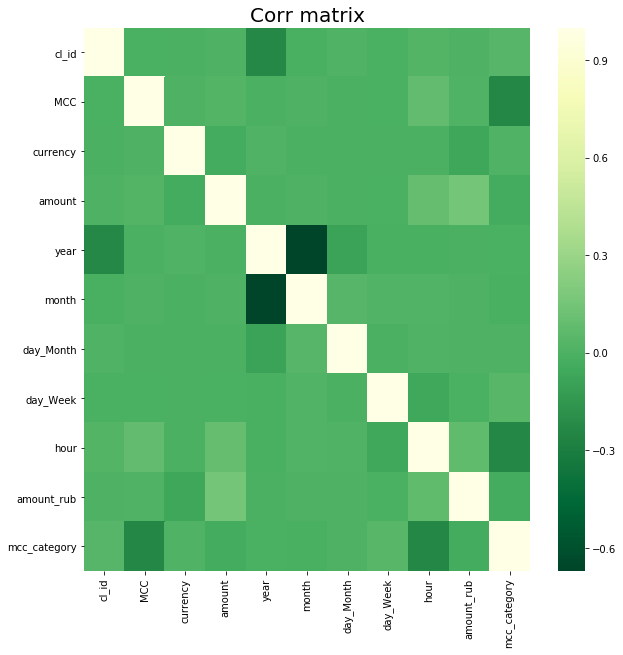

In [42]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Corr matrix', size=20)
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    ax=ax, cmap = 'YlGn_r'
)
plt.show()

## Сохраним в датасет количество операций по каждой категории и сумму расходов по каждой категории

для начала вытягнем подготовим данные

In [43]:
# df_grouped = df[
#     ['cl_id', 'amount_rub', 'mcc_category']
# ].groupby(['cl_id', 'mcc_category']).agg(['sum', 'count'])
# agg_dataset = df_grouped.unstack()

In [44]:
# agg_dataset.head()

In [45]:
# agg_dataset.fillna(0, inplace=True)

In [46]:
# agg_dataset.head()

In [47]:
#agg_dataset.columns['amount']

In [48]:
#agg_dataset['amount_rub']['sum'][0]

In [49]:
# for i in range(len(agg_dataset['amount_rub']['sum'].columns)):
#    df['mcc_category_' + str(i)] = agg_dataset['amount_rub']['sum'][i]

# Формируем фичи

In [50]:
data_ = pd.DataFrame({
        'amount_sum' : df.groupby( [ "cl_id", "target_flag" ] )['amount_rub'].sum(),
        'amount_mean': df.groupby( [ "cl_id", "target_flag"] )['amount_rub'].mean(),
    }).reset_index()

In [51]:
data_.head()

,cl_id,target_flag,amount_mean,amount_sum
0,0,0,12876.600000,64383.000000
1,1,0,3162.148698,328863.464609
2,2,y,1651.847839,328717.720000
3,3,y,3026.790645,290571.901888
4,4,y,2221.997123,351075.545430


In [52]:
df_short = pd.DataFrame(df, columns = ["cl_id", "target_flag", "mcc_category", 'day_Month', 'day_Week', 'hour'])

In [53]:
df_dummies = pd.get_dummies(df_short, columns= ['mcc_category', 'day_Month', 'day_Week', 'hour'])

In [54]:
df_dummies = df_dummies.groupby( [ "cl_id", "target_flag"] ).sum().reset_index()

In [55]:
df_dummies.head(10)

,cl_id,target_flag,mcc_category_0,mcc_category_1,mcc_category_2,mcc_category_3,mcc_category_4,mcc_category_5,mcc_category_6,mcc_category_7,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,70.0,4.0,0.0,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,2,y,2.0,2.0,0.0,112.0,23.0,0.0,6.0,4.0,...,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,y,2.0,0.0,0.0,49.0,18.0,0.0,0.0,0.0,...,4.0,2.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0
4,4,y,0.0,0.0,0.0,106.0,12.0,0.0,2.0,2.0,...,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,1,2.0,0.0,0.0,25.0,30.0,0.0,0.0,6.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
6,6,y,0.0,0.0,0.0,136.0,38.0,0.0,2.0,2.0,...,2.0,2.0,4.0,5.0,2.0,6.0,2.0,0.0,0.0,0.0
7,7,y,3.0,0.0,0.0,82.0,30.0,1.0,0.0,0.0,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,y,3.0,0.0,0.0,82.0,30.0,0.0,2.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,9,0,0.0,0.0,0.0,28.0,10.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0


In [56]:
del df_dummies['target_flag']
del df_dummies['cl_id']

In [57]:
df_dummies.shape

(10217, 83)

In [58]:
data_.shape

(10217, 4)

In [59]:
data_full = pd.concat([data_, df_dummies], axis=1)

In [60]:
data_full.head()

,cl_id,target_flag,amount_mean,amount_sum,mcc_category_0,mcc_category_1,mcc_category_2,mcc_category_3,mcc_category_4,mcc_category_5,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,12876.600000,64383.000000,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,3162.148698,328863.464609,0.0,0.0,0.0,70.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,2,y,1651.847839,328717.720000,2.0,2.0,0.0,112.0,23.0,0.0,...,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,y,3026.790645,290571.901888,2.0,0.0,0.0,49.0,18.0,0.0,...,4.0,2.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0
4,4,y,2221.997123,351075.545430,0.0,0.0,0.0,106.0,12.0,0.0,...,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Разделим на X_train и X_test

In [64]:
X_train = data_full[data_full.target_flag!='y'].drop('target_flag', axis=1)
X_test = data_full[data_full.target_flag=='y'].drop('target_flag', axis=1)

In [65]:
Y_train = data_full[data_full.target_flag!='y']['target_flag'].apply(int)

In [66]:
X_train.shape[0] == Y_train.shape[0]

True

In [71]:
X_train.head(2)

,cl_id,amount_mean,amount_sum,mcc_category_0,mcc_category_1,mcc_category_2,mcc_category_3,mcc_category_4,mcc_category_5,mcc_category_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,12876.600000,64383.000000,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3162.148698,328863.464609,0.0,0.0,0.0,70.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0


# Применим Lasso регрессию и посмотрим, какие переменные получают 0 в качестве коэффициентов

In [88]:
from sklearn.linear_model import Lasso

In [68]:
model_l = Lasso(tol=0.0001, max_iter = 100000)

In [69]:
model_l.fit(X_train,Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [70]:
model_l.coef_

array([-6.15291298e-05, -6.00535146e-07,  2.39724559e-08,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [186]:
model_l.intercept_

0.7683933047955075

# PCA 

In [188]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train,Y_train)

Text(0,0.5,'explained_variance_ratio_')

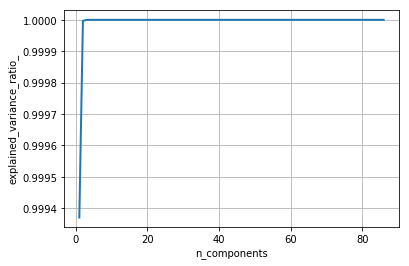

In [189]:
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [190]:
np.set_printoptions(suppress=True)
pca.explained_variance_ratio_ * 100

array([99.93707388,  0.06257494,  0.00035082,  0.0000003 ,  0.00000002,
        0.00000001,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [191]:
pca.components_[-1]

array([ 0.        ,  0.        , -0.        , -0.01176186, -0.01176186,
       -0.01176186, -0.01176186, -0.01176186, -0.01176186, -0.01176186,
       -0.01176186, -0.01176186, -0.01176186, -0.01176186, -0.01176186,
       -0.01176186, -0.01176186, -0.01176186, -0.01176186, -0.01176186,
       -0.01176186, -0.01176186, -0.01176186, -0.01176186, -0.00886384,
       -0.00886384, -0.00886384, -0.00886384, -0.00886384, -0.00886384,
       -0.00886384, -0.00886384, -0.00886384, -0.00886384, -0.00886384,
       -0.00886384, -0.00886384, -0.00886384, -0.00886384, -0.00886384,
       -0.00886384, -0.00886384, -0.00886384, -0.00886384, -0.00886384,
       -0.00886384, -0.00886384, -0.00886384, -0.00886384, -0.00886384,
       -0.00886384, -0.00886384, -0.00886384, -0.00886384, -0.00886384,
        0.19488561,  0.19488561,  0.19488561,  0.19488561,  0.19488561,
        0.19488561,  0.19488561, -0.17425992, -0.17425992, -0.17425992,
       -0.17425992, -0.17425992, -0.17425992, -0.17425992, -0.17

In [192]:
#pca = PCA(n_components=3)
#pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_pca

array([[-534149.30546166,    9276.48280997,   -5166.16067534, ...,
              0.        ,       0.        ,       0.        ],
       [-269862.18125268,   -4744.96543267,   -5106.24941366, ...,
              0.        ,       0.        ,       0.        ],
       [ -40666.2503764 ,   -7710.90256037,   -5082.54536025, ...,
              0.        ,       0.        ,       0.        ],
       ...,
       [  78712.86929562,   -4396.12684695,    5119.20272862, ...,
              0.        ,      -0.        ,      -0.        ],
       [-376592.18069232,   -4057.15294574,    5099.95814259, ...,
              0.        ,       0.        ,      -0.        ],
       [-534137.04013262,    -876.31414025,    5083.80369321, ...,
              0.        ,       0.        ,       0.        ]])

# обучаем модель 

# LogisticRegression

In [307]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_pca,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [308]:
lr.score(X_train_pca,Y_train)

0.7106

In [309]:
lr_predictions = lr.predict_proba( X_train_pca )

In [346]:
from sklearn.metrics import roc_auc_score

In [311]:
roc_auc_score( Y_train, lr_predictions[:, 1] )

0.7674537617959475

# GridSearchCV

In [282]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [283]:
depths = np.arange(1,10)
#features_num = np.arange(5,15)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)

In [292]:
%%time
gridsearch.fit(X_train,Y_train)

CPU times: user 1.77 s, sys: 8.47 ms, total: 1.78 s
Wall time: 1.78 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [293]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.89537, std: 0.14080, params: {'max_depth': 1},
 mean: -14.67347, std: 5.62684, params: {'max_depth': 2},
 mean: -17.83253, std: 1.89457, params: {'max_depth': 3},
 mean: -18.26472, std: 2.27045, params: {'max_depth': 4},
 mean: -24.07825, std: 8.50753, params: {'max_depth': 5},
 mean: -26.82085, std: 8.00615, params: {'max_depth': 7},
 mean: -27.20186, std: 8.21899, params: {'max_depth': 6},
 mean: -27.36859, std: 8.33747, params: {'max_depth': 9},
 mean: -27.38753, std: 8.35117, params: {'max_depth': 8}]

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


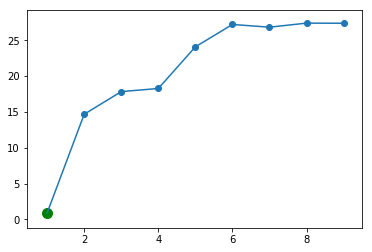

In [294]:
scores = [-x.mean_validation_score for x in gridsearch.grid_scores_]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

In [295]:
dtc = DecisionTreeClassifier(max_depth=2)

In [296]:
dtc.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [297]:
dtc.score(X_train,Y_train)

0.708

In [298]:
dtc_predictions = dtc.predict_proba( X_train )

In [299]:
roc_auc_score( Y_train, dtc_predictions[:, 1] )

0.7573449381270625

In [321]:

dtc_predictions = dtc.predict(X_test)

In [322]:
submission = '_ID_,_VAL_\n'
submission += '\n'.join(['{},{}'.format(uid, prediction) for uid, prediction in zip(data_full[data_full.target_flag=='y'].cl_id, dtc_predictions)])
with open('dtc_predictions.txt', 'w') as file:
    file.write(submission)


# GradientBoosting

In [384]:
from sklearn.ensemble import GradientBoostingClassifier as gb, GradientBoostingRegressor as gb_reg

In [385]:
gb=gb()

In [386]:
gb.fit(X_train_pca, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [387]:
gb_pred = gb.predict_proba( X_train_pca )

In [382]:
roc_auc_score( Y_train, gb_pred[:,1] )

0.8925941025563422

# Подготавливаем решение для отправки

In [392]:
X_test_pca = pca.transform(X_test)
gb_predictions = gb.predict(X_test_pca)

In [393]:
submission = '_ID_,_VAL_\n'
submission += '\n'.join(['{},{}'.format(uid, prediction) for uid, prediction in zip(data_full[data_full.target_flag=='y'].cl_id, gb_predictions)])
with open('gb_predictions.txt', 'w') as file:
    file.write(submission)


![Dscreen](screen.png)

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
3. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
4. **Обязательная часть**: на большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов
5. **Обязательная часть**: на фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в *sklearn.decomposition.pca.components_* после построения главных компонент)
6. **Обязательная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
8. **Дополнительная часть**: поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого необходимо использовать все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.
9. Задания принимаются в виде ноутбука с кодом/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    